In [112]:
import requests
from bs4 import BeautifulSoup

In [142]:
# Top 50 games
import requests
app_ids = {}
for page in range(1, 2):

  url = f'https://steamcharts.com/top/p.{page}'
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  result = requests.get(url, headers=headers)
  soup = BeautifulSoup(result.content.decode(), 'html.parser')

  table_body = soup.select_one('#top-games tbody')

  if table_body:
      rows = table_body.find_all('tr')

      for row in rows:
          link = row.find('a')
          if link:
              href = link['href']
              app_id = href.split('/')[-1]
              name = link.text.strip()

              app_ids[app_id] = name
          else:
              print("Link not found in the row.")
  else:
      print("Table body not found.")

In [143]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
# Preprocess text (username and link placeholders)
def preprocess(text, max_length=512):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    preprocessed_text = " ".join(new_text)
    preprocessed_text = preprocessed_text[:max_length]  # Truncate to max_length
    return preprocessed_text

# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# config = AutoConfig.from_pretrained(MODEL)

# # PT
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# text = preprocess(text)
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)

# print(scores) # toxic, neutral, positive

# ranking = np.argsort(scores)
# ranking = ranking[::-1]
# for i in range(scores.shape[0]):
#     l = config.id2label[ranking[i]]
#     s = scores[ranking[i]]
#     print(f"{i+1}) {l} {np.round(float(s), 4)}")


model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

print(model('woah'))

[{'label': 'non-toxic', 'score': 0.9974936246871948}]


In [144]:
game_toxicity = {}
for app_id in app_ids:
  print(f'Game: {app_ids[app_id]}')
  cursor = '*'
  batch = 0

  # Up to 400 recent reviews
  for batch in range(3):
    print(f'Batch: {batch}')
    page = requests.get(f'https://store.steampowered.com/appreviews/{app_id}?json=1&cursor={cursor}&filter=recent&num_per_page=100').json()
    reviews = page['reviews']
    toxicity_scores = []
    for review in reviews:
        review_text = preprocess(review['review'])
        output = model(review_text)[0]
        if output['label'] == 'non-toxic':
          toxicity_scores.append(1 - output['score'])
        else:
          toxicity_scores.append(output['score'])

    if 'cursor' in page:
        cursor = urllib.parse.quote(page['cursor'])
    else:
      break

  if len(toxicity_scores) > 0:
    game_toxicity[app_ids[app_id]] = np.mean(toxicity_scores)
  else
    game_toxicity[app_ids[app_id]] = -1



Game: Counter-Strike 2
Batch: 0
Batch: 1
Batch: 2
Game: Dota 2
Batch: 0
Batch: 1
Batch: 2
Game: PUBG: BATTLEGROUNDS
Batch: 0
Batch: 1
Batch: 2
Game: Apex Legends
Batch: 0
Batch: 1
Batch: 2
Game: NARAKA: BLADEPOINT
Batch: 0
Batch: 1
Batch: 2
Game: Stardew Valley
Batch: 0
Batch: 1
Batch: 2
Game: Wallpaper Engine
Batch: 0
Batch: 1
Batch: 2
Game: Grand Theft Auto V
Batch: 0
Batch: 1
Batch: 2
Game: Destiny 2
Batch: 0
Batch: 1
Batch: 2
Game: Fallout 4
Batch: 0
Batch: 1
Batch: 2
Game: HELLDIVERS™ 2
Batch: 0
Batch: 1
Batch: 2
Game: Call of Duty®
Batch: 0
Batch: 1
Batch: 2
Game: Team Fortress 2
Batch: 0
Batch: 1
Batch: 2
Game: Tom Clancy's Rainbow Six Siege
Batch: 0
Batch: 1
Batch: 2
Game: Lost Ark
Batch: 0
Batch: 1
Batch: 2
Game: Monster Hunter: World
Batch: 0
Batch: 1
Batch: 2
Game: Manor Lords
Batch: 0
Batch: 1
Batch: 2
Game: Unturned
Batch: 0
Batch: 1
Batch: 2
Game: Baldur's Gate 3
Batch: 0
Batch: 1
Batch: 2
Game: War Thunder
Batch: 0
Batch: 1
Batch: 2
Game: 7 Days to Die
Batch: 0
Batch: 1


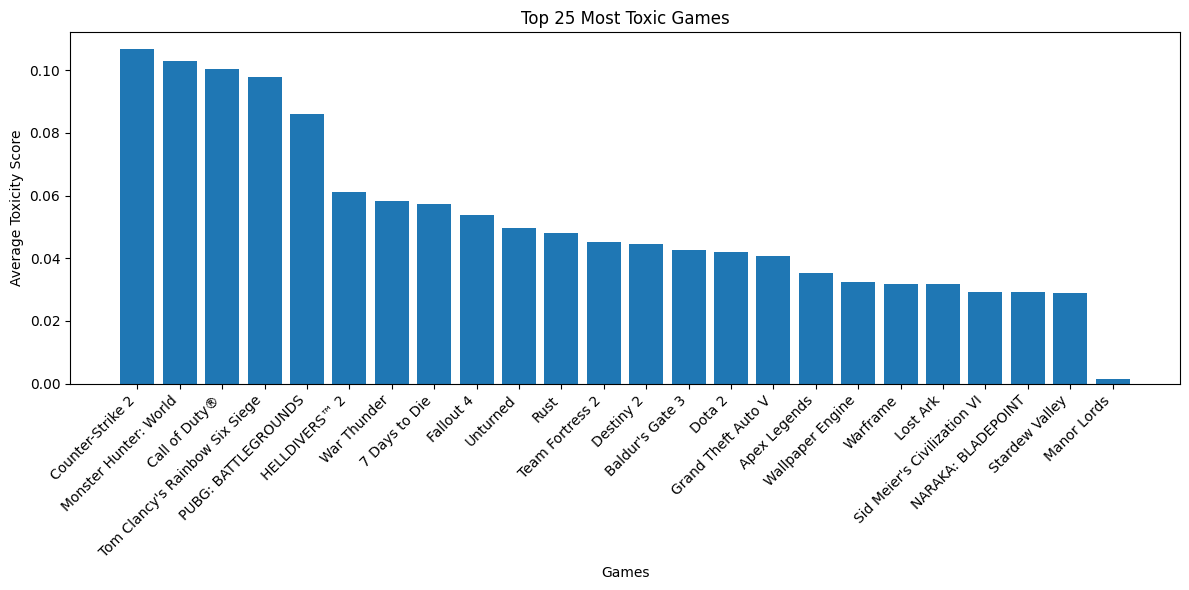

In [147]:
import matplotlib.pyplot as plt

# ...

# Plot the most toxic games
num_games_to_plot = 25
sorted_toxicity = sorted(game_toxicity.items(), key=lambda x: x[1], reverse=True)
most_toxic_games = sorted_toxicity[:num_games_to_plot]

games = [game[0] for game in most_toxic_games]
toxicity_scores = [game[1] for game in most_toxic_games]

plt.figure(figsize=(12, 6))
plt.bar(range(len(games)), toxicity_scores)
plt.xlabel('Games')
plt.ylabel('Average Toxicity Score')
plt.title(f'Top {num_games_to_plot} Most Toxic Games')
plt.xticks(range(len(games)), games, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [128]:
game_toxicity['Crab Game']

nan